외부 요소와 코로나 전파 간 상관 분석

이번 코로나 사태가 장기화 됨에 따라 다양한 시점에서 이번 사태를 분석하고 있다.
이번 연구는 그러한 다양한 시점 중 하나인 코로나 외부 요소와 코로나 전파 간의 상관 관계를 분석하여, 현 사태에 대한 이해를 돕고, 코로나 대응에 기여할 수 있는 자료를 만드는 것을 목표로 한다.

그러한 관점에서 개입이 불가능한 외부 요소로써 날씨 변화에 따른 코로나 전파 관계에 대한 추적과, 정부의 코로나에 대해서 개입하므로 만들어지는 외부 요소인 정부의 코로나 정책이 코로나 전파에 어떠한 영향을 미치게 되었는지 확인하고, 더 나아가 나타난 현상에 대한 근거를 제시하려고 한다.

먼저 개입이 불가능한 외부 요소로써 날씨를 선정한 이유에 대해서 짧게 언급하자면, 코로나는 사람 간 감염이 주된 전파 사유이며, 이것은 유동인구와 실내 밀집 정도, 혹은 건습 여하에 따라서 사람들의 행동 양식에 영향을 미치며, 코로나 병원이 전파되기 쉬운 환경을 조성하는 사유로도 볼수 있기 때문에 선정하였습니다.
이에 날씨와 확진자 간 상관 관계를 분석하여 각 요소가 끼치는 영향에 대하여 조사한다.
각 자료는 공공데이터와 기상청의 자료를 가공하여 준비했다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cfm_day = pd.read_csv("./cfm_wx/Time_extend.csv",index_col=0)#일일 확진자 누계
cfm_pr = pd.read_csv("./cfm_wx/TimeProvince_ext.csv",index_col=0)#시도별 일일 확진자 누계
cfm_ages = pd.read_csv("./cfm_wx/TimeAge_ext.csv",index_col=0)#나이별 일일 확진자 누계
cfm_gen = pd.read_csv("./cfm_wx/TimeGender_ext.csv",index_col=0)#성별 일일 확진자 누계

wx = pd.read_csv("./cfm_wx/wx_summary.csv",index_col=0)#일일 기상 관측(지상)
wx.fillna(0)#기상 데이터에서 결측치 제거

display(cfm_day.head(2))
display(cfm_pr.head(2))
display(cfm_ages.head(2))
display(cfm_gen.head(2))
# display(wx.columns)

,date,test,negative,confirmed,released,deceased
0,2020-01-20,1,0,1,0,0
1,2020-01-21,1,0,1,0,0


,province,confirmed,released,deceased
date,,,,
2020-01-20,Seoul,0,0,0
2020-01-21,Seoul,0,0,0


,date,age,confirmed,deceased
0,2020-03-02,0s,32,0
1,2020-03-02,10s,169,0


,date,sex,confirmed,deceased
0,2020-03-02,female,2621,9
1,2020-03-02,male,1591,13


In [2]:
pr_names = cfm_pr['province'].unique()
age_groups = cfm_ages['age'].unique()
gens = cfm_gen['sex'].unique()

prs_cfm={}
ages_cfm={}
gens_cfm={}
prs_wx={}

for i in pr_names:#지역별 확진자 테이블 분류
    t = cfm_pr[cfm_pr['province'] == i]
    t.reset_index(drop=False,inplace=True)
    t['diff_cfm'] = t['confirmed'].diff()
    prs_cfm[i] = t

    t = wx[wx['province'] == i]
    t.reset_index(drop=False,inplace=True)
    t['diff_temp'] = t['max_temp'] - t['min_temp']
    prs_wx[i]=t

for i in age_groups:#나이별 확진자 테이블 분류
    t = cfm_ages[cfm_ages['age'] == i]
    t.reset_index(drop=False,inplace=True)
    cfm_diff = t['confirmed'].diff()
    cfm_diff.name = 'diff_cfm'
    ages_cfm[i]=t.merge(cfm_diff,left_index=True,right_index=True)

for i in gens:#성별 확진자 테이블 분류
    t = cfm_gen[cfm_gen['sex'] == i]
    t.reset_index(drop=False,inplace=True)
    cfm_diff = t['confirmed'].diff()
    cfm_diff.name = 'diff_cfm'
    gens_cfm[i]=t.merge(cfm_diff,left_index=True,right_index=True)


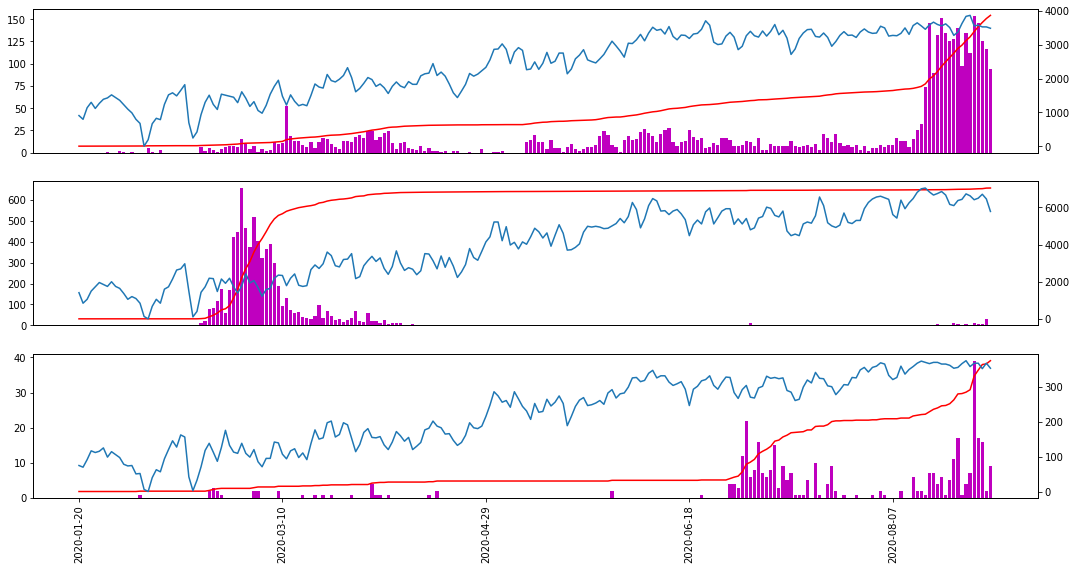

In [3]:

fig = plt.figure(figsize=(18,9))

subplts = [fig.add_subplot(3,1,i+1) for i in range(3)]
sample_prs = ['Seoul','Daegu','Gwangju']

for idx, i in enumerate(sample_prs):
    if idx != 2 :
        subplts[idx].get_xaxis().set_visible(False)
    ax2 = subplts[idx].twinx()
    ax3 = subplts[idx].twinx()
    ax3.get_yaxis().set_visible(False)
    subplts[idx].bar(range(prs_cfm[i].shape[0]),prs_cfm[i]['diff_cfm'],color='m')
    ax3.plot(prs_wx[i]['avg_temp'])
    ax2.plot(prs_cfm[i]['confirmed'], color = 'r')

    dates = prs_cfm[i]['date']
    ndtrng = range(0,len(prs_cfm[i]['date']),50)
    subplts[idx].set_xticks(ndtrng)
    subplts[idx].set_xticklabels(prs_cfm[i]['date'][::50],rotation='vertical')
fig.show()

평균 기온과 확진자의 관계는 얼핏 비례하는 듯이 보이나, 이는 계절적으로 겨울 - 봄 - 여름을 거치며, 확진자 수는 누적되므로 인과관계는 없다고 봐도 전무하다.
그 반례로 일일 확진자 수와 기온과의 그래프는 불규칙적인 모습을 보여준다.

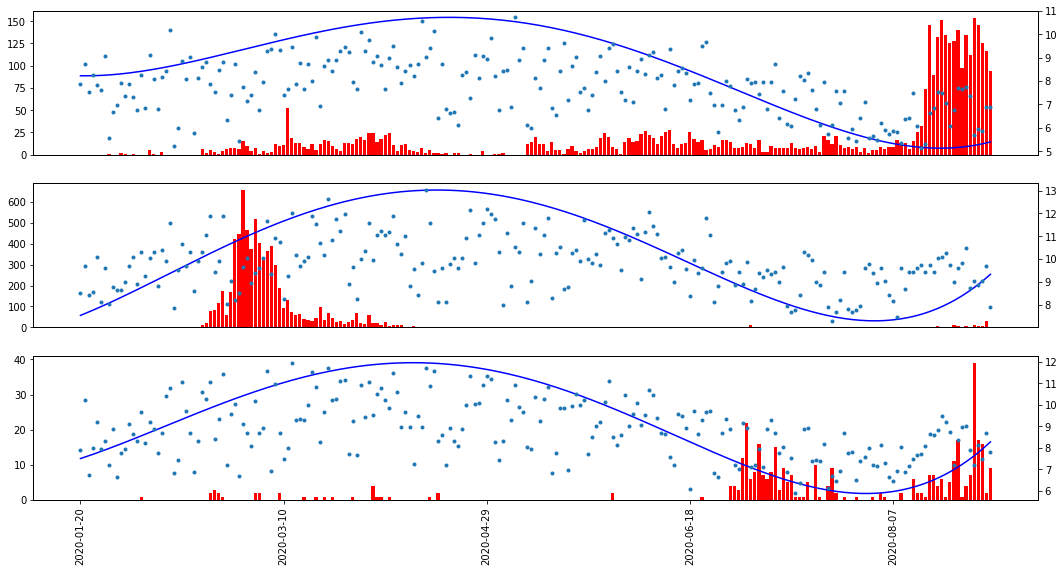

In [4]:
from sklearn import preprocessing as pp
from sklearn.linear_model import LinearRegression
fig = plt.figure(figsize=(18,9))

subplts = [fig.add_subplot(3,1,i+1) for i in range(3)]
sample_prs = ['Seoul','Daegu','Gwangju']

for idx, i in enumerate(sample_prs):
    pr = LinearRegression()
    poly = pp.PolynomialFeatures(4)

    X = np.arange(len(prs_wx[i]['diff_temp']))[:,np.newaxis]
    y = prs_wx[i]['diff_temp'].values

    qx = poly.fit_transform(X)

    pr.fit(qx,y)
    X_fit = np.arange(len(prs_wx[i]['diff_temp']))[:,np.newaxis]
    y_qd_fit = pr.predict(qx)

    if idx != 2 :
        subplts[idx].get_xaxis().set_visible(False)
    ax2 = subplts[idx].twinx()
    ax3 = subplts[idx].twinx()
    ax3.get_yaxis().set_visible(False)
    subplts[idx].bar(prs_cfm[i].index,prs_cfm[i]['diff_cfm'],color='r')
    ax3.scatter(prs_wx[i].index,prs_wx[i]['diff_temp'],marker = '.')
    ax2.plot(X_fit,y_qd_fit,color = 'b')

    dates = prs_cfm[i]['date']
    ndtrng = range(0,len(prs_cfm[i]['date']),50)
    subplts[idx].set_xticks(ndtrng)
    subplts[idx].set_xticklabels(prs_cfm[i]['date'][::50],rotation='vertical')
fig.show()

일교차와 일일 확진자 수의 비교이나, 실제로 이 데이터 또한 큰 추세에서 유사성을 보기는 힘들다.
확진자는 잠복기를 거쳐서 확진이 되므로 큰 추세에서 연관된 뒤이어 따라오는 형태의 그래프를 그려야하지만 다항회귀그래프와 일일 확진자 그래프로 보아 큰 연관이 있다고는 할수 없다.

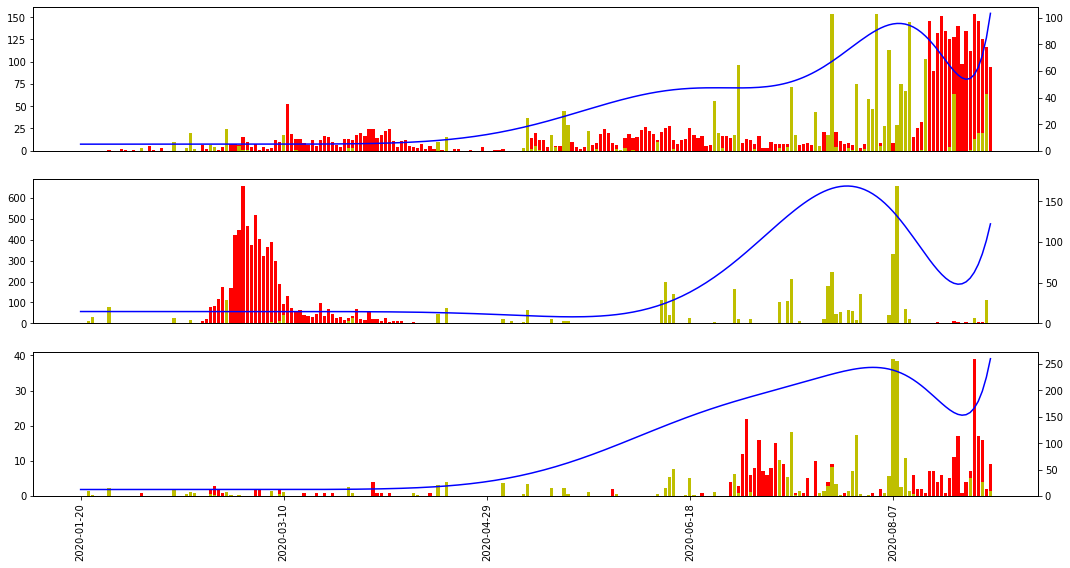

In [5]:
fig = plt.figure(figsize=(18,9))

subplts = [fig.add_subplot(3,1,i+1) for i in range(3)]
sample_prs = ['Seoul','Daegu','Gwangju']

for idx, i in enumerate(sample_prs):

    pr = LinearRegression()
    poly = pp.PolynomialFeatures(15)

    X = np.arange(len(prs_wx[i]['avg_humi']))[:,np.newaxis]
    y = prs_wx[i]['avg_humi'].values

    qx = poly.fit_transform(X)

    pr.fit(qx,y)
    X_fit = np.arange(len(prs_wx[i]['avg_humi']))[:,np.newaxis]
    y_qd_fit = pr.predict(qx)

    if idx != 2 :
        subplts[idx].get_xaxis().set_visible(False)
    ax2 = subplts[idx].twinx()
    ax3 = subplts[idx].twinx()
    ax3.get_yaxis().set_visible(False)
    subplts[idx].bar(range(prs_cfm[i].shape[0]),prs_cfm[i]['diff_cfm'],color='r')
    ax2.bar(range(prs_cfm[i].shape[0]),prs_wx[i]['day_rain'],color='y')
    ax3.plot(X_fit,y_qd_fit,color='b')
    # ax3.plot(prs_wx[i]['avg_humi'],color='b')

    dates = prs_cfm[i]['date']
    ndtrng = range(0,len(prs_cfm[i]['date']),50)
    subplts[idx].set_xticks(ndtrng)
    subplts[idx].set_xticklabels(prs_cfm[i]['date'][::50],rotation='vertical')
fig.show()

코로나 병원과 밀접한 원관을 지닌 습도를 회귀분석하여 그래프를 표현하였다.
그러나 그래프간 큰 관계를 보인다고 하기 어렵다.
실내 활동이 주된 활동 공간인 현대인에게 있어 외부 요인인 날씨에 큰 영향을 받지 않는다고 볼수 있다.

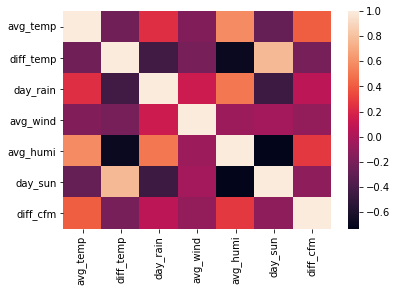

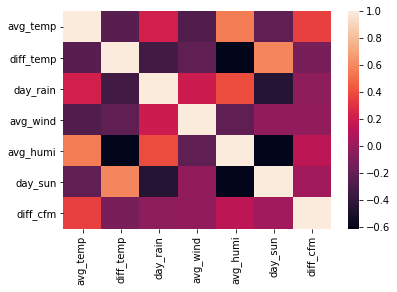

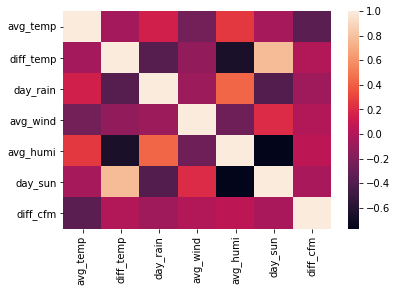

In [6]:
import seaborn as sns

for idx, i in enumerate(pr_names[:3]):
    fig, axs = plt.subplots(1,1)
    t = prs_wx[i][['avg_temp','diff_temp', 'day_rain','avg_wind', 'avg_humi', 'day_sun']]
    t = t.merge(prs_cfm[i][['diff_cfm']],left_index=True,right_index=True)
    sns.heatmap(data = t.corr() , ax = axs)
    fig.show()


서울, 대구, 광주의 각 요소를 히트맵으로 표시하였다.
대체로 약한 상관 계수를 나타내므로써 일일 발생 확진자와 큰 연관을 나타내지 않았다.

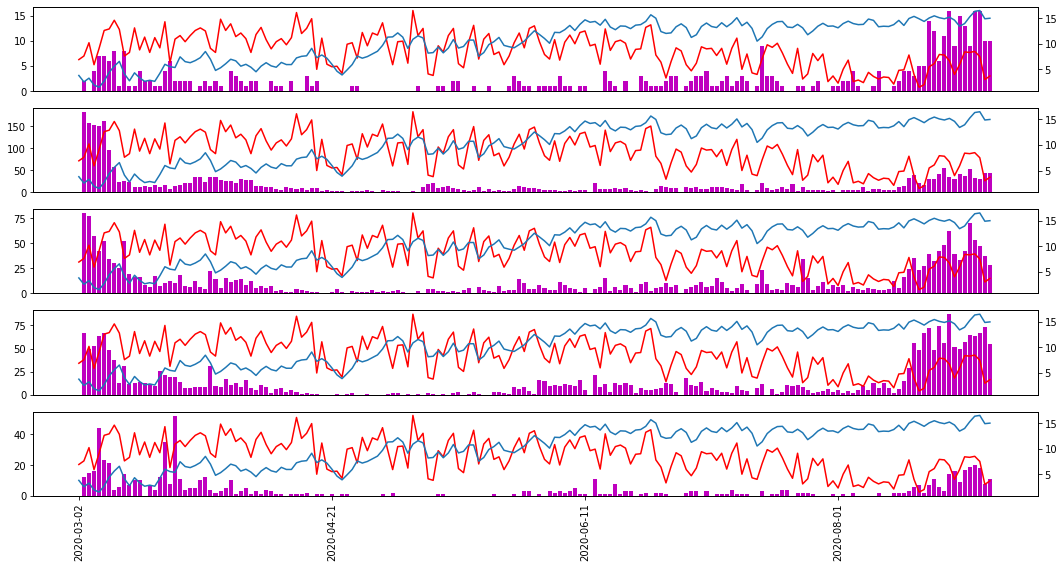

In [7]:
fig = plt.figure(figsize=(18,9))
subplts = [fig.add_subplot(5,1,i+1) for i in range(5)]

lx = ages_cfm[age_groups[0]].shape[0]

mini_wx = prs_wx['Seoul'][prs_wx['Seoul']['date']>='2020-03-01'].iloc[:lx,:]
mini_wx.reset_index(drop=True,inplace=True)

for idx , i in enumerate(age_groups[::2]):
    if idx != 4 :
        subplts[idx].get_xaxis().set_visible(False)
    ax2 = subplts[idx].twinx()
    ax3 = subplts[idx].twinx()
    ax3.get_yaxis().set_visible(False)
    subplts[idx].bar(range(ages_cfm[i].shape[0]),ages_cfm[i]['diff_cfm'],color='m')
    ax3.plot(mini_wx['avg_temp'])
    ax2.plot(mini_wx['diff_temp'], color = 'r')

    dates = ages_cfm[i]['date']
    ndtrng = range(0,len(ages_cfm[i]['date']),50)
    subplts[idx].set_xticks(ndtrng)
    subplts[idx].set_xticklabels(ages_cfm[i]['date'][::50],rotation='vertical')


연령별(유아, 20대, 40대, 60대, 80대) 확진자 수와 일교차 간 그래프를 통해 관계를 확인하였다.
보는 것과 같이 큰 영향을 끼친다고 보기는 어려우나, 집단 발생 중 짧은 기간동안 일교차와 일일 발생 확진자 수가 비례하는 것으로 보인다.

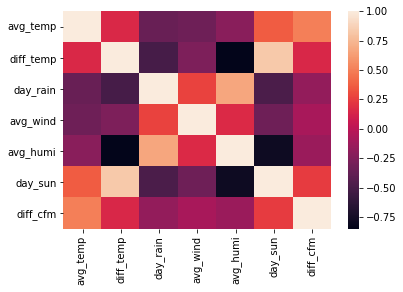

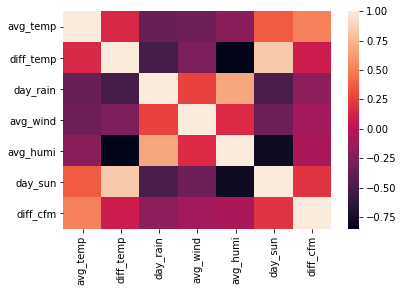

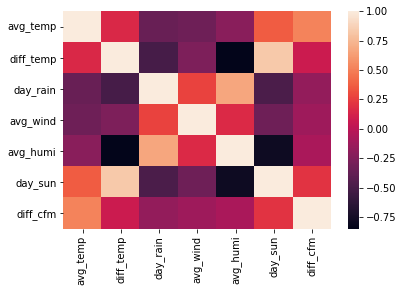

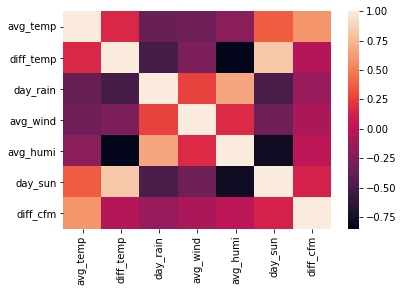

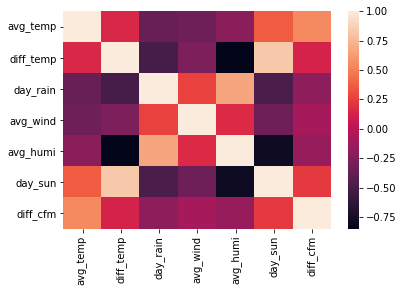

In [8]:
for i in age_groups[::2]:
    fig, axs = plt.subplots(1,1)
    t = mini_wx[['avg_temp','diff_temp', 'day_rain','avg_wind', 'avg_humi', 'day_sun']]
    t = t.merge(ages_cfm[i]['diff_cfm'],left_index=True,right_index=True)
    sns.heatmap(data=t[120:].corr(),ax = axs)

특정 구간 내에서 비교적 높은 상관계수를 가지는 것을 확인할 수 있으나, 직접적인 상관 관계가 있다고 할 정도는 아니다.

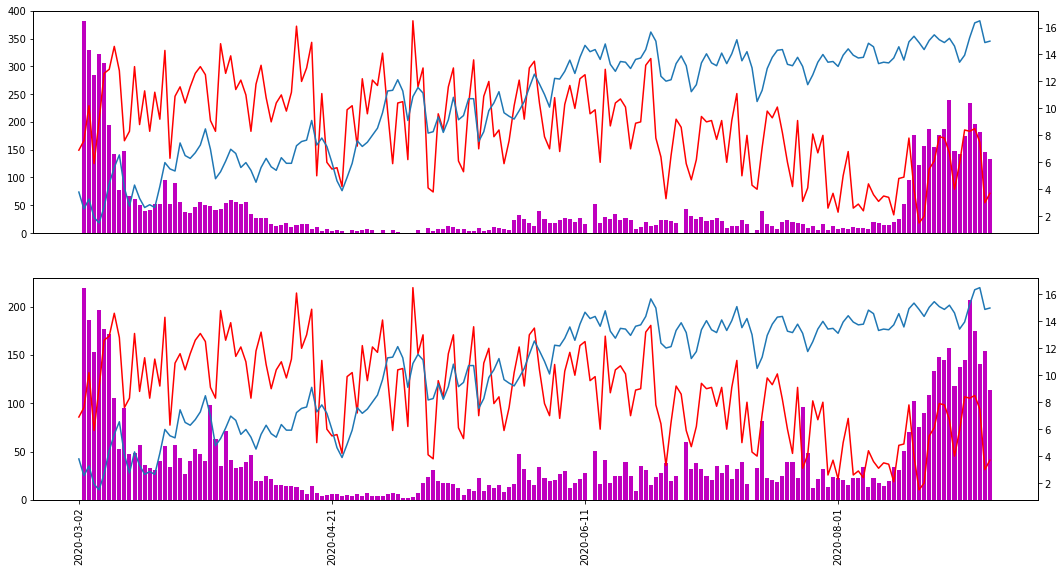

In [9]:
fig = plt.figure(figsize=(18,9))
subplts = [fig.add_subplot(2,1,i+1) for i in range(2)]

lx = gens_cfm[gens[0]].shape[0]
for idx , i in enumerate(gens):
    if idx != 1 :
        subplts[idx].get_xaxis().set_visible(False)
    ax2 = subplts[idx].twinx()
    ax3 = subplts[idx].twinx()
    ax3.get_yaxis().set_visible(False)
    subplts[idx].bar(gens_cfm[i].index,gens_cfm[i]['diff_cfm'],color='m')
    ax3.plot(mini_wx['avg_temp'])
    ax2.plot(mini_wx['diff_temp'], color = 'r')

    dates = gens_cfm[i]['date']
    ndtrng = range(0,len(gens_cfm[i]['date']),50)
    subplts[idx].set_xticks(ndtrng)
    subplts[idx].set_xticklabels(gens_cfm[i]['date'][::50],rotation='vertical')


남녀 발생 추이 또한 비슷한 형태를 그리고 있으며 집단 감염시 일일 여성 확진자 증가폭이 더 큰것이 특징이지만 날씨나 기상현상과 어떠한 현상이나, 관계를 나타낸다고 보기에 어렵다.

위의 경우를 보아 날씨와 코로나 전염 간의 관계를 특정하기에 어려움이 따른다.
일부 구간에서 비슷한 형태를 보이는 것으로, 집단 감염이 발생되었을 경우에 전파에 어떠한 변수로써 작용한다고 추정되지만, 실제 확진자가 잠복기를 거친다는 것을 가정하면 인과 관계를 나타낸다고 보기 힘들다.
이는 현대인의 주된 활동 공간이 야외에서 실내로 옮긴 까닭이 크며, 특히 야외같은 경우에는 실내보다 환기가 잘 되며 사람들이 밀집되지 않은 까닭에 크게 영향을 주는 요인이라고 보기 힘들다.
특히 주된 집단 감염이 밀집된 실내 공간에서 발생하는 것으로 보아 실외 외부 요소인 날씨가 코로나 전파에는 다소 영향력이 낮다고 볼 수 있다.

이외 기상요소가 아닌 정부의 코로나 대응 정책이 코로나 전파에 끼치는 영향을 조사하여 정책과 코로나 

In [10]:
# Time_fix_2.csv와 Policy_fix_2.csv 파일 불러오기
time = pd.read_csv('./spd_policy/Time.csv', header='infer')
policy = pd.read_csv('./spd_policy/Policy.csv', header='infer')

In [11]:
# 그래프에 시간순 연속변수로 사용하기 위해 날짜(str)을 datetime 타입으로 변경
time['datetime'] = pd.to_datetime(time["date"])
policy['start_datetime'] = pd.to_datetime(policy['start_date'])
policy['end_datetime'] = pd.to_datetime(policy['end_date'])

# time과 policy 데이터프레임 정보 확인
display(time.head(3))
display(policy.head(3))

,date,time,test,negative,confirmed,released,deceased,datetime
0,2020-01-20,16,1,0,1,0,0,2020-01-20
1,2020-01-21,16,1,0,1,0,0,2020-01-21
2,2020-01-22,16,4,3,1,0,0,2020-01-22


,policy_id,country,type,gov_policy,detail,start_date,end_date,color,start_datetime,end_datetime
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19,g,2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27,g,2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22,y,2020-01-28,2020-02-22


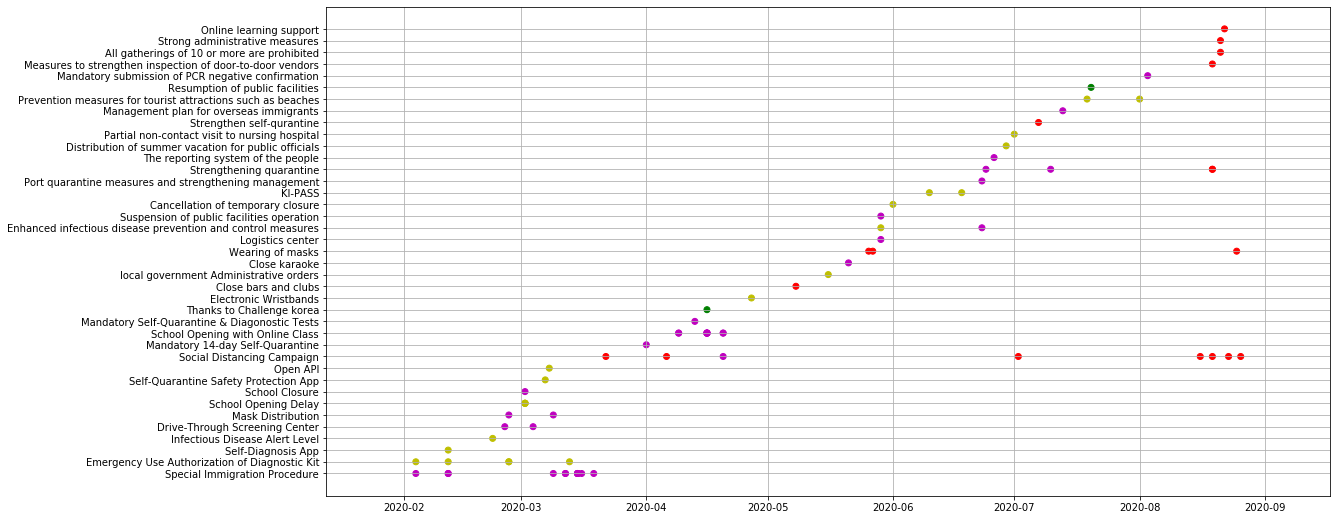

In [12]:
# 그래프의 X 축(정책시행 날짜)을 시간 순서로 정렬
df_plc = policy.sort_values('start_date', ascending=True)

# 감염을 통한 확진자가 발견된 2월 자료부터 슬라이싱
df_plc = df_plc.iloc[4:]

# 시간 순서에 의한 정부 정책 시각화
# 일별 정례브리핑 내용을 바탕으로 정책 별 규제강도 분류
# 해당 그래프를 토대로 규제강도가 강한 정책의 선별 필요성 확인(그린, 옐로 제거)
x_plc = df_plc['start_datetime']
y_plc = df_plc['gov_policy']

plt.figure(figsize=(18,9))
plt.scatter(x_plc, y_plc, color=df_plc['color'])
plt.xticks()
plt.grid()

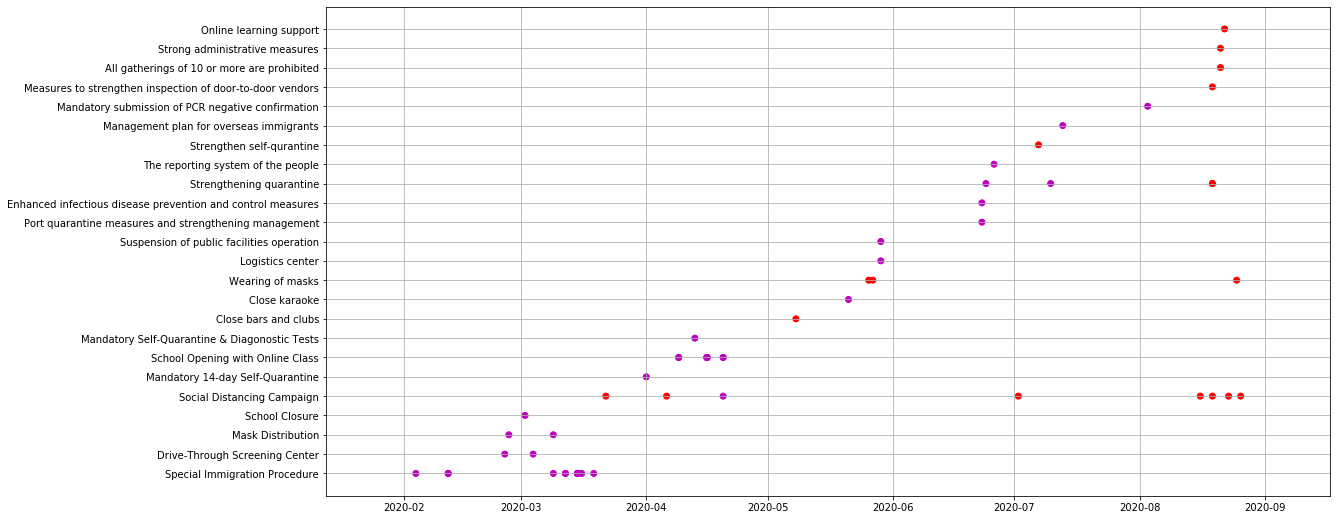

In [13]:
# 규제강도 m:의무, r:강제 로 유의미한 정책 분류(정례브리핑의 정책피드백 참고)
df_plc2 = df_plc[(df_plc['color'] == 'm') | (df_plc['color'] == 'r')]
df_plc2['date'] = df_plc['start_date']

x_plc = df_plc2['start_datetime']
y_plc = df_plc2['gov_policy']

plt.figure(figsize=(18,9))
plt.scatter(x_plc, y_plc, color=df_plc2['color'])
plt.xticks()
plt.grid()

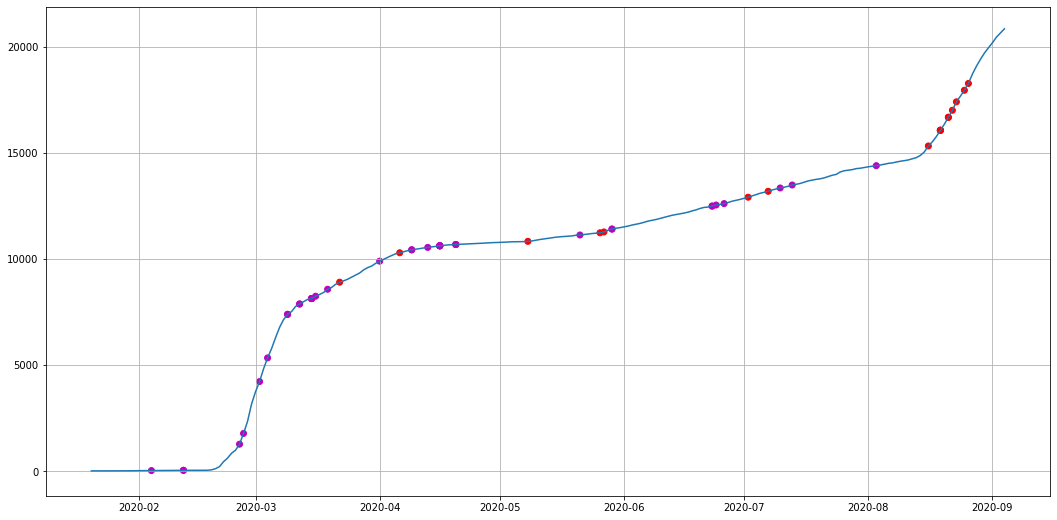

In [14]:
# 정책데이터에 누적확진자데이터 병렬 후 수치 적용하여 누적확진자 그래프와 함께 시각화
df_plc3 = df_plc2.merge(time, left_on = 'date', right_on = 'date' , how='inner')

x_time = time["datetime"]
y_time = time['confirmed']
x_plc = df_plc3['start_datetime']
y_plc = df_plc3['confirmed']
# x_ticks = df_plc['start_date'].apply(lambda x: convert_str(x))

plt.figure(figsize=(18,9))
plt.plot(x_time, y_time)
plt.scatter(x_plc, y_plc, color=df_plc3['color'])
plt.xticks()
plt.grid()

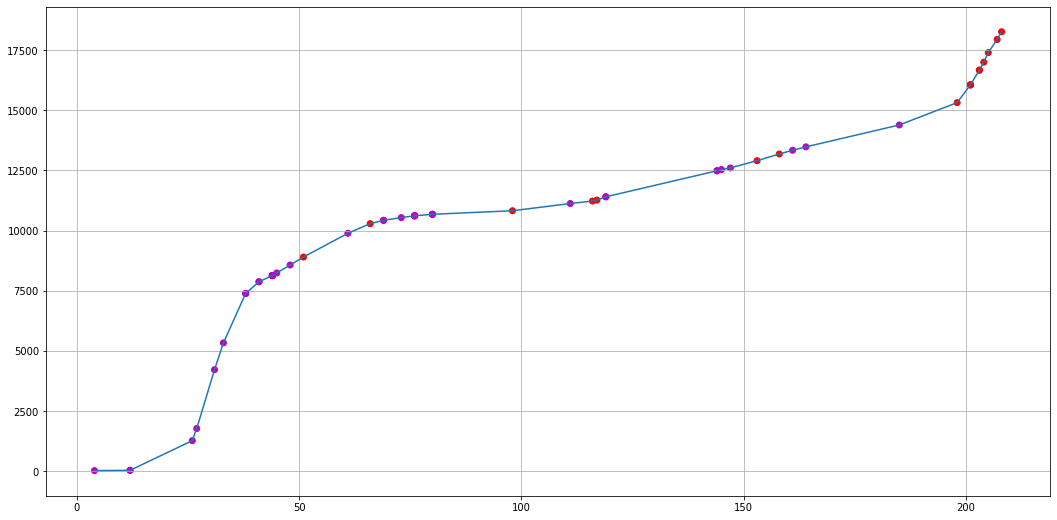

In [15]:
# 날짜데이터(datetime)을 연속형 변수(num)로 변환
dateNum = pd.read_csv('./spd_policy/dateNumbering.csv', header='infer')
dateNum['date'] = pd.to_datetime(dateNum['date'])
df_plc3['date'] = pd.to_datetime(df_plc3['date'])
dfx = df_plc3.merge(dateNum, left_on = 'date', right_on = 'date' , how='inner')

dfx_x = dfx['num']
dfx_y = dfx['confirmed']
df_plc2['date'] = pd.to_datetime(df_plc2['date'])

# 정책데이터에 일자데이터(num) 병합 : 일자데이터 이용을 위한 데이터테이블
dfy = df_plc2.merge(dateNum, left_on = 'date', right_on = 'date' , how='inner')

dfy_x = dfy['num']
dfy_y = dfy['gov_policy']

# dfx_x 와 dfy_x가 같은데 왜 구분한 것인지 모르겠음 양준에게 문의중
plt.figure(figsize=(18,9))
plt.plot(dfx_x,  dfx_y)
plt.scatter(dfy_x, dfx_y, color=dfy['color'])
plt.xticks()
plt.grid()
plt.show()